In [ ]:
#FALTA LIMPIAR EL DF DE DATOS NULOS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from gapminder import gapminder

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from formulaic import Formula

In [2]:
pd.options.display.max_rows = 100 # Para poder ver los datos completos

Trabajaremos con el dataset sube-2023.csv1 que contiene datos sobre la utilización de la SUBE
durante el año 2023 a nivel nacional.

In [3]:
datos = pd.read_csv('./sube-2023.csv')

Vamos a hacer una visualización general de los datos, para tener una idea de con qué valores, qué datos y qué tipo de datos tenemos.

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


In [5]:
datos.describe()

,CANTIDAD
count,472291.000000
mean,9336.927454
std,20609.074234
min,-417.000000
25%,683.000000
50%,2627.000000
75%,9062.000000
max,542616.000000


In [107]:
datos.head()

array(['BUENOS AIRES', 'JN', 'CHUBUT', nan, 'SANTA FE', 'ENTRE RÍOS',
       'LA PAMPA', 'MENDOZA', 'RÍO NEGRO', 'TIERRA DEL FUEGO', 'CHACO',
       'JUJUY', 'NEUQUÉN', 'FORMOSA', 'CORRIENTES', 'CATAMARCA',
       'SAN JUAN', 'SAN LUIS', 'CORDOBA', 'SANTA CRUZ',
       'SANTIAGO DEL ESTERO'], dtype=object)

Procesamiento de datos [2 pts.]
1. (a) Visualizar el tipo de datos de cada columna. Transformar la columna DIA_TRANSPORTE
para que sea reconocida como una fecha.
Sugerencia: investigar la función to_datetime de pandas. Para completar el argumento
format, revisar la documentación de datetime

In [7]:
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

### (b) Agregar tres columnas al DataFrame:

i. FECHA_DIA : debe indicar el nombre del día de la semana correspondiente a
DIA_TRANSPORTE

In [8]:
# Diccionario para traducir los días de la semana
dias_semana = {
    'Monday': 'Mon',
    'Tuesday': 'Tue',
    'Wednesday': 'Wed',
    'Thursday': 'Thu',
    'Friday': 'Fri',
    'Saturday': 'Sat',
    'Sunday': 'Sun'
}
# Agregar una nueva columna 'FECHA_DIA' con el nombre del día de la semana
datos['FECHA_DIA'] = datos['DIA_TRANSPORTE'].dt.day_name().map(dias_semana)

ii. FECHA_ORDINAL : debe indicar el ordinal correspondiente a DIA_TRANSPORTE (por
ejemplo, a 2023-01-01 le corresponde 1, a 2023-01-02 le corresponde 2 y así sucesivamente). Debe ser un entero (int).

In [9]:
# Calcular el ordinal de la fecha
fecha_base = pd.Timestamp('2023-01-01') #primer fecha del anio

datos['FECHA_ORDINAL'] = datos['DIA_TRANSPORTE'].dt.dayofyear

# Asegurarse de que la nueva columna sea de tipo int
datos['FECHA_ORDINAL'] = datos['FECHA_ORDINAL'].astype(int)

iii. FECHA_MES : debe indicar el mes correspondiente a DIA_TRANSPORTE
Sugerencia: investigar el método apply de DataFrame.

In [10]:
# Agregar la columna 'FECHA_MES' con el número del mes en formato 'MM'
datos['FECHA_MES'] = datos['DIA_TRANSPORTE'].dt.month.apply(lambda x: f'{x:02d}')

2. Crear el DataFrame datos_amba, el cual sólo debe tener datos de AMBA y debe excluir datos
preliminares. Además, al ejecutar datos_amba.head() debe observarse el siguiente orden y
formato de columnas:

In [11]:
#Verificamos que los valores vistos en los datos sean unicamente "SI" y "NO"
datos['AMBA'].unique()

array(['SI', 'NO'], dtype=object)

In [12]:
#Armamos nuevo df con sólo los datos de AMBA
datos_amba = datos[datos.AMBA == 'SI']

In [13]:
# Lista de nombres de columnas en el orden deseado
orden_columnas = ['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL','JURISDICCION','LINEA','CANTIDAD','TIPO_TRANSPORTE']

# Reorganizar las columnas
datos_amba = datos_amba[orden_columnas]
# datos_amba.head()
datos_amba.rename(columns={'DIA_TRANSPORTE': 'fecha', 'FECHA_DIA': 'fecha_dia', 'FECHA_MES':'fecha_mes', 'FECHA_ORDINAL':'fecha_ordinal', 'JURISDICCION':'jurisdiccion', 'LINEA':'linea', 'CANTIDAD':'pasajeros','TIPO_TRANSPORTE':'tipo_transporte'}, inplace=True)

3. Utilizando datos_amba, identificar:

(a) la proporción de la cantidad total anual de pasajeros que le corresponde a cada medio de
transporte

In [14]:
# Ya habiamos verificado que 'pasajeros' sea de tipo numerico
# Agrupamos los datos por 'tipo_transporte' y sumamos la cantidad de pasajeros por cada tipo
suma_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

# Calculamos el total anual de pasajeros
total_anual = suma_por_transporte.sum()

# Calculamos la proporción de pasajeros por cada tipo de transporte
proporcion_por_transporte = suma_por_transporte / total_anual

# Resultado
print(proporcion_por_transporte)

tipo_transporte
COLECTIVO    0.837677
SUBTE        0.068084
TREN         0.094240
Name: pasajeros, dtype: float64


(b) la tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [15]:
# Filtrar los datos para incluir solo las líneas de subte (asumiendo que se identifican por la palabra 'subte' en 'TIPO_TRANSPORTE')
subte_datos = datos_amba[datos_amba['tipo_transporte'].str.contains('SUBTE', case=False, na=False)]

# Agrupar los datos por 'MES' y 'LINEA' y sumar la cantidad de pasajeros
suma_por_mes_linea = subte_datos.groupby(['fecha_mes', 'linea'])['pasajeros'].sum().reset_index()

# Crear un DataFrame con los valores de suma_por_mes_linea
df_suma_por_mes_linea = pd.DataFrame(suma_por_mes_linea, columns=['fecha_mes', 'linea', 'pasajeros'])

#Tenemos que tener en cuenta que si hay más de un valor máximo (si justo dos lineas tienen el mismo numero de pasajeros, tenerlo en cuenta)

In [16]:
# Encontrar la tupla (mes, línea de subte) con la mayor cantidad de pasajeros
tupla_max_pasajeros = suma_por_mes_linea['pasajeros'].idxmax()
max_pasajeros = df_suma_por_mes_linea['pasajeros'].max()

suma_por_mes_linea_unico = suma_por_mes_linea[suma_por_mes_linea['pasajeros'] == max_pasajeros]
# Verificamos que hay un unico valor maximo de pasajeros:
# print(suma_por_mes_linea_unico)

tupla_mes_max = (suma_por_mes_linea_unico.fecha_mes.item(), suma_por_mes_linea_unico.pasajeros.item())
# print(tupla_mes_max)
# print(type(tupla_mes_max))
# Entonces mostramos el resultado de la tupla
print(f"Tupla (mes, línea de subte) con la mayor cantidad de pasajeros: {tupla_mes_max[0]} con {tupla_mes_max[1]} pasajeros")

Tupla (mes, línea de subte) con la mayor cantidad de pasajeros: 08 con 5227906 pasajeros


(c) el día hábil con menor desvío estándar en cantidad de pasajeros

In [17]:
# Filtrar los datos para incluir solo días hábiles (lunes a viernes)
dias_habiles = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
datos_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

# Agrupar los datos por el nombre del día de la semana y calcular el desvío estándar de la cantidad de pasajeros para cada día
desvio_estandar_por_dia = datos_habiles.groupby('fecha_dia')['pasajeros'].std()
# Chequeamos nuevamente que el valor de mínimo std sea único:
df_desvio_estandar_por_dia = pd.DataFrame(desvio_estandar_por_dia.reset_index()).rename(columns={'pasajeros': 'std'})
# print(df_desvio_estandar_por_dia) # Lo es

In [18]:
# Encontrar el día hábil con el menor desvío estándar
dia_menor_desvio_estandar = desvio_estandar_por_dia.idxmin()
menor_desvio_estandar = desvio_estandar_por_dia.min()

# Mostrar el resultado
print(f"El día hábil con menor desvío estándar en cantidad de pasajeros es: {dia_menor_desvio_estandar} con un desvío estándar de {menor_desvio_estandar}")

El día hábil con menor desvío estándar en cantidad de pasajeros es: Mon con un desvío estándar de 33573.89534333799


## Análisis Exploratorio

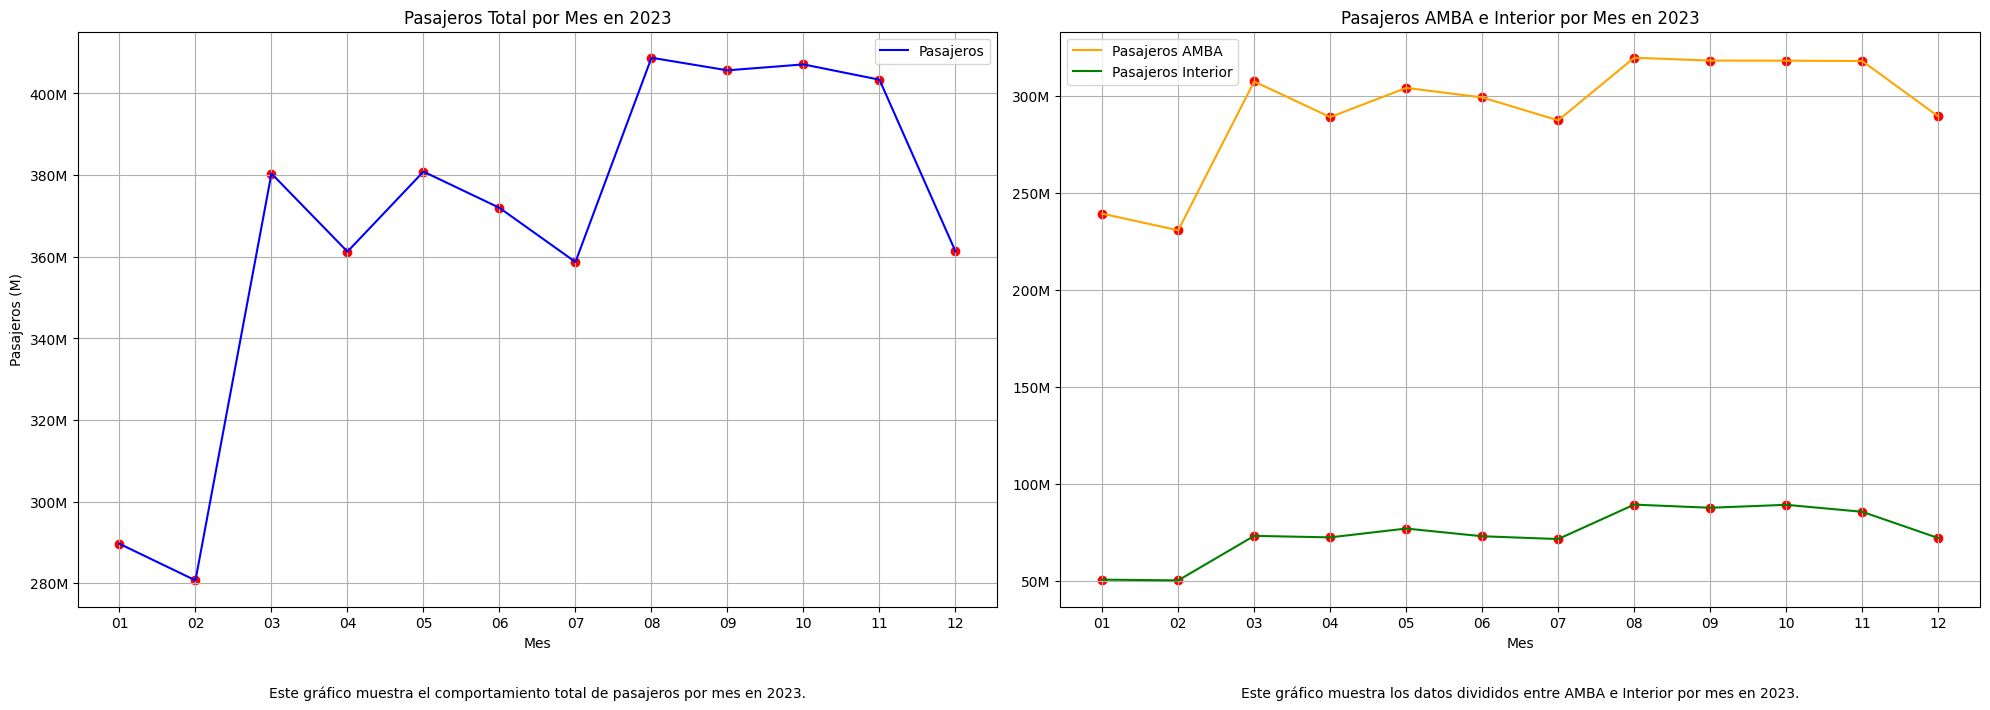

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Supongamos que 'datos' es tu DataFrame
# datos = pd.read_csv('tu_archivo.csv')

# Filtrar los datos
datosAMBA = datos[datos['AMBA'] == 'SI']
datosINT = datos[datos['AMBA'] == 'NO']

# Agrupar los datos por mes y sumar la cantidad
datos_agg = datos.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()
datos_aggAMBA = datosAMBA.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()
datos_aggINT = datosINT.groupby('FECHA_MES')['CANTIDAD'].sum().reset_index()

# Función para formatear los valores del eje Y
def millones(x, pos):
    return f'{x * 1e-6:.0f}M'

formatter = FuncFormatter(millones)

# Crear una figura con dos subplots dispuestos horizontalmente
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: Pasajeros Total
ax1.plot(datos_agg['FECHA_MES'], datos_agg['CANTIDAD'], label='Pasajeros', color='blue')
ax1.scatter(datos_agg['FECHA_MES'], datos_agg['CANTIDAD'], color='red')
ax1.set_title('Pasajeros Total por Mes en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')
ax1.legend()
ax1.grid(True)
ax1.yaxis.set_major_formatter(formatter)
# Descripción específica para el primer gráfico
ax1.text(0.5, -0.15, 'Este gráfico muestra el comportamiento total de pasajeros por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Segundo gráfico: Pasajeros AMBA e Interior
ax2.plot(datos_aggAMBA['FECHA_MES'], datos_aggAMBA['CANTIDAD'], label='Pasajeros AMBA', color='orange')
ax2.plot(datos_aggINT['FECHA_MES'], datos_aggINT['CANTIDAD'], label='Pasajeros Interior', color='green')
ax2.scatter(datos_aggAMBA['FECHA_MES'], datos_aggAMBA['CANTIDAD'], color='red')
ax2.scatter(datos_aggINT['FECHA_MES'], datos_aggINT['CANTIDAD'], color='red')
ax2.set_title('Pasajeros AMBA e Interior por Mes en 2023')
ax2.set_xlabel('Mes')
ax2.legend()
ax2.grid(True)
ax2.yaxis.set_major_formatter(formatter)
# Descripción específica para el segundo gráfico
ax2.text(0.5, -0.15, 'Este gráfico muestra los datos divididos entre AMBA e Interior por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=10)

# Ajustar el layout
plt.tight_layout(rect=[0, 0.2, 1, 0.95])

# Mostrar el gráfico
plt.show()


• Podemos observar la diferencia de volumen entre el AMBA y el Interior

• El comportamiento es similar en ambos (identificando el aumento y disminución del uso de transporte público en los mismos meses para los distintos sectores del país).

¿Y en todos los medios de transporte por igual?


In [20]:
# display(datos_aggAMBA)
datos_aggAMBA = datosAMBA.groupby(['FECHA_MES', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().reset_index()
datos_aggINT = datosINT.groupby(['FECHA_MES', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().reset_index()

In [21]:
#Creo los dataframes para plotear los valores de los transportes de las localidades
datos_aggAMBA_colectivo = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'COLECTIVO']
datos_aggAMBA_subte = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'SUBTE']
datos_aggAMBA_tren = datos_aggAMBA[datos_aggAMBA['TIPO_TRANSPORTE'] == 'TREN']

datos_aggINT_colectivo = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'COLECTIVO']
datos_aggINT_lanchas = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'LANCHAS']
datos_aggINT_tren = datos_aggINT[datos_aggINT['TIPO_TRANSPORTE'] == 'TREN']

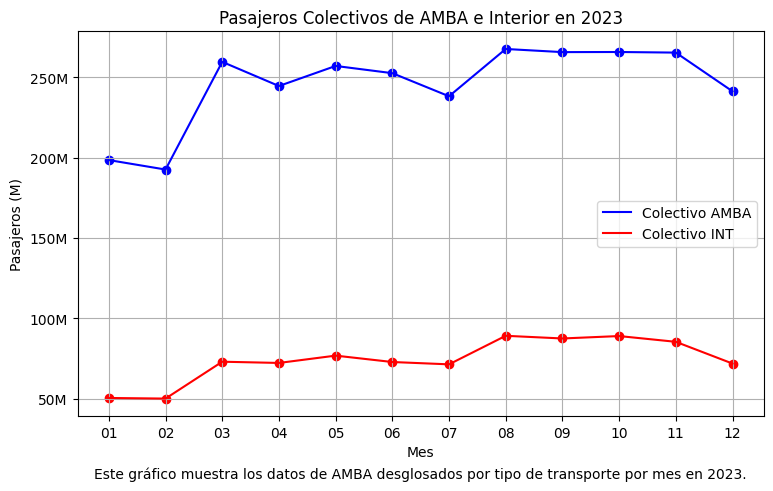

In [22]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(8, 7))

# Plotting the data
ax1.plot(datos_aggAMBA_colectivo['FECHA_MES'], datos_aggAMBA_colectivo['CANTIDAD'], label='Colectivo AMBA', color='blue')
ax1.scatter(datos_aggAMBA_colectivo['FECHA_MES'], datos_aggAMBA_colectivo['CANTIDAD'], color='blue')
ax1.plot(datos_aggINT_colectivo['FECHA_MES'], datos_aggINT_colectivo['CANTIDAD'], label='Colectivo INT', color='red')
ax1.scatter(datos_aggINT_colectivo['FECHA_MES'], datos_aggINT_colectivo['CANTIDAD'], color='red')
ax1.set_title('Pasajeros Colectivos de AMBA e Interior en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')

# Adding legend
ax1.legend()

# Adding grid
ax1.grid(True)

ax1.yaxis.set_major_formatter(formatter)

# Adding specific description
plt.text(0.5, -0.15, 'Este gráfico muestra los datos de AMBA desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Adjusting the layout
plt.tight_layout(rect=[0, 0.2, 1, 0.95])

# Display the plot
plt.show()


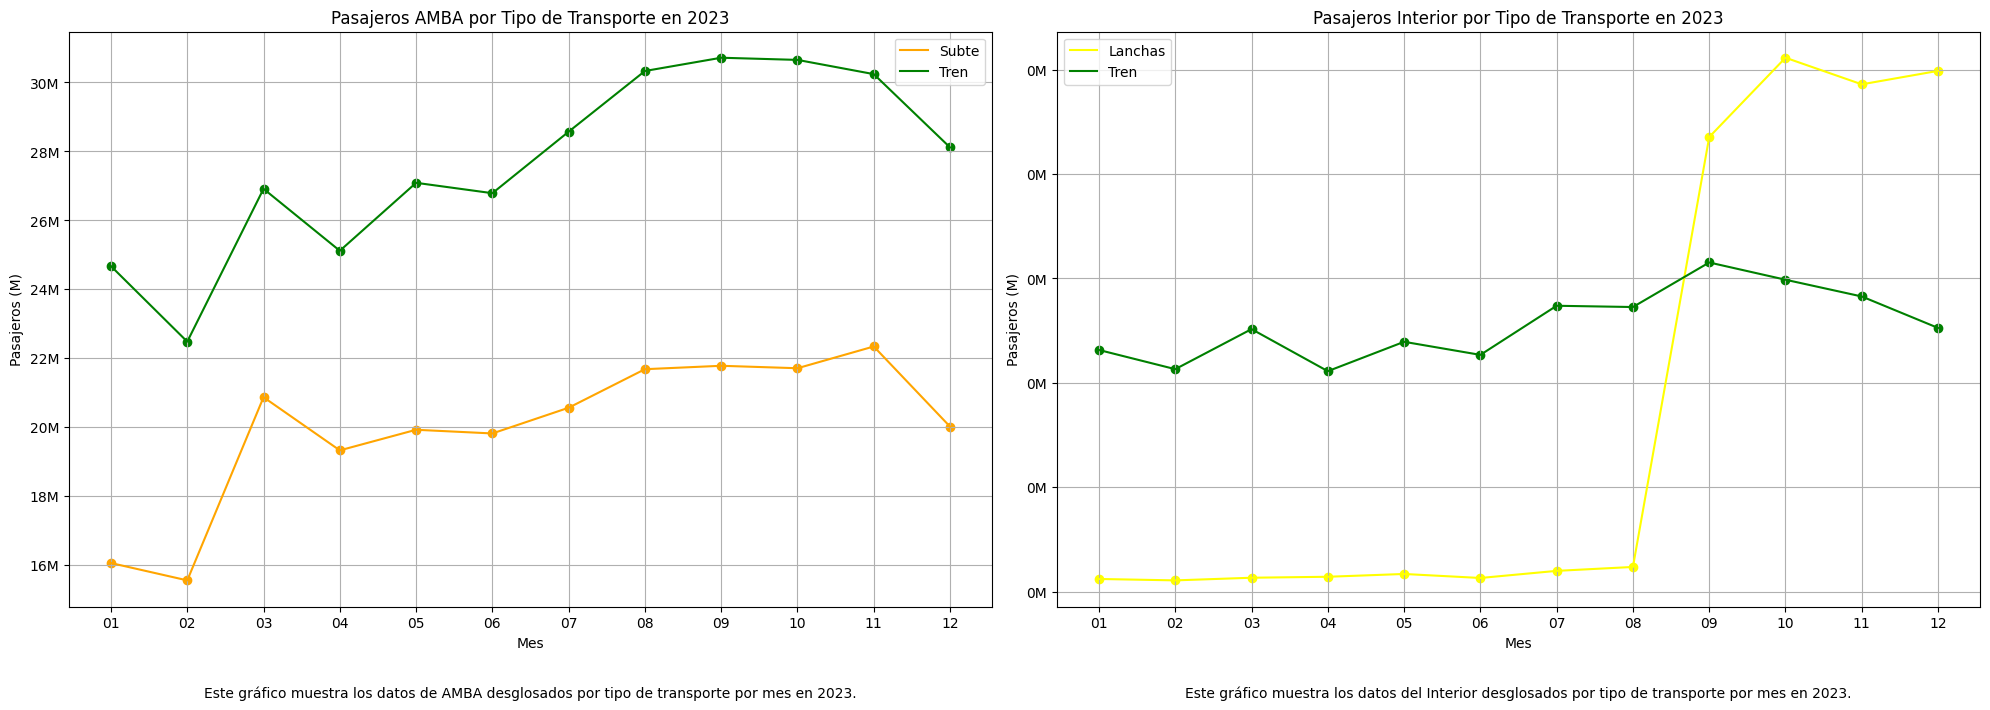

In [23]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: Pasajeros AMBA desglosados por tipo de transporte
ax1.plot(datos_aggAMBA_subte['FECHA_MES'], datos_aggAMBA_subte['CANTIDAD'], label='Subte', color='orange')
ax1.plot(datos_aggAMBA_tren['FECHA_MES'], datos_aggAMBA_tren['CANTIDAD'], label='Tren', color='green')
ax1.scatter(datos_aggAMBA_subte['FECHA_MES'], datos_aggAMBA_subte['CANTIDAD'], color='orange')
ax1.scatter(datos_aggAMBA_tren['FECHA_MES'], datos_aggAMBA_tren['CANTIDAD'], color='green')
ax1.set_title('Pasajeros AMBA por Tipo de Transporte en 2023')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Pasajeros (M)')
ax1.legend()
ax1.grid(True)
ax1.yaxis.set_major_formatter(formatter)

# Descripción específica para el primer gráfico
ax1.text(0.5, -0.15, 'Este gráfico muestra los datos de AMBA desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=10)

# Segundo gráfico: Pasajeros Interior desglosados por tipo de transporte
ax2.plot(datos_aggINT_lanchas['FECHA_MES'], datos_aggINT_lanchas['CANTIDAD'], label='Lanchas', color='yellow')
ax2.plot(datos_aggINT_tren['FECHA_MES'], datos_aggINT_tren['CANTIDAD'], label='Tren', color='green')
ax2.scatter(datos_aggINT_lanchas['FECHA_MES'], datos_aggINT_lanchas['CANTIDAD'], color='yellow')
ax2.scatter(datos_aggINT_tren['FECHA_MES'], datos_aggINT_tren['CANTIDAD'], color='green')
ax2.set_title('Pasajeros Interior por Tipo de Transporte en 2023')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Pasajeros (M)')
ax2.legend()
ax2.grid(True)
ax2.yaxis.set_major_formatter(formatter)

# Descripción específica para el segundo gráfico
ax2.text(0.5, -0.15, 'Este gráfico muestra los datos del Interior desglosados por tipo de transporte por mes en 2023.',
         horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=10)

# Ajustar el layout
plt.tight_layout(rect=[0, 0.2, 1, 0.95])

# Mostrar el gráfico
plt.show()

• ¿Cómo difiere el uso del transporte público durante los días hábiles en comparación a los
fines de semana?

• ¿Hay algún día hábil que resulte un outlier? ¿Pueden explicarlo?

In [24]:
# Calcular estadísticas descriptivas
desc_stats = datos_habiles['pasajeros'].describe()
print(desc_stats)

# Calcular IQR y definir umbrales para detectar outliers
Q1 = desc_stats['25%']
Q3 = desc_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = datos_habiles[(datos_habiles['pasajeros'] < lower_bound) | (datos_habiles['pasajeros'] > upper_bound)]
print(outliers)

count    107283.000000
mean      27318.378625
std       35312.298554
min        -417.000000
25%        7549.000000
50%       18965.000000
75%       34876.500000
max      542616.000000
Name: pasajeros, dtype: float64
            fecha fecha_dia fecha_mes  fecha_ordinal jurisdiccion  \
964    2023-01-02       Mon        01              2     NACIONAL   
1050   2023-01-02       Mon        01              2   PROVINCIAL   
1131   2023-01-02       Mon        01              2   PROVINCIAL   
1186   2023-01-02       Mon        01              2    MUNICIPAL   
1287   2023-01-02       Mon        01              2     NACIONAL   
...           ...       ...       ...            ...          ...   
468920 2023-12-29       Fri        12            363     NACIONAL   
469263 2023-12-29       Fri        12            363          NaN   
469264 2023-12-29       Fri        12            363          NaN   
469750 2023-12-29       Fri        12            363          NaN   
469755 2023-12-29       F

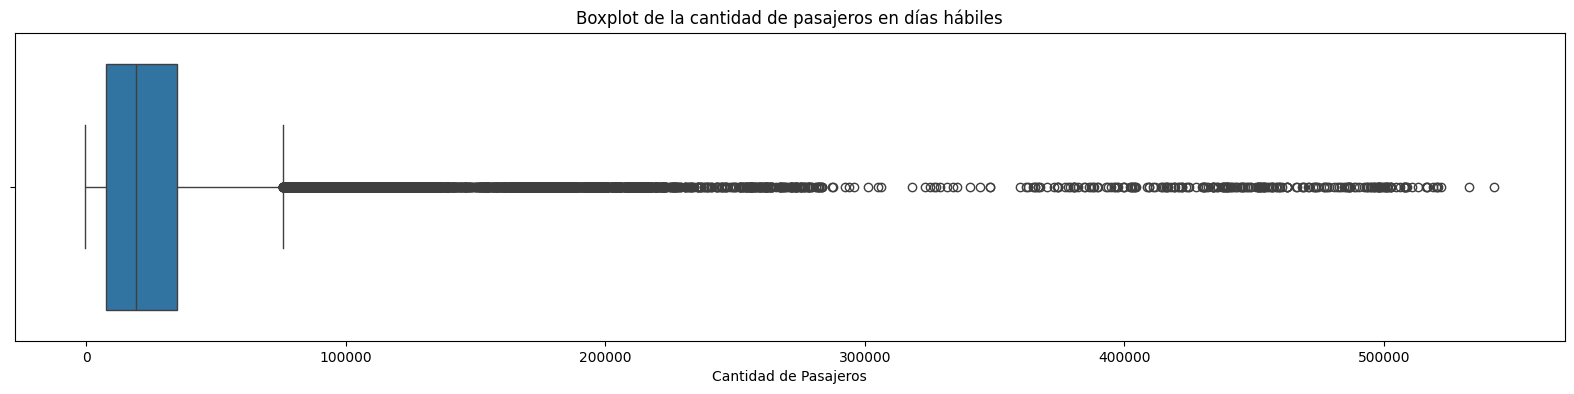

In [25]:
# Visualizar los outliers con un boxplot
plt.figure(figsize=(20, 4))
sns.boxplot(x='pasajeros', data=datos_habiles[datos_habiles['pasajeros']<10000000]) #los outliers estan a partir de 10k
plt.title('Boxplot de la cantidad de pasajeros en días hábiles')
plt.xlabel('Cantidad de Pasajeros')
plt.show()

In [26]:
display(datos.describe())
display(datos[datos['CANTIDAD'] > 9062])

,CANTIDAD,FECHA_ORDINAL
count,472291.000000,472291.000000
mean,9336.927454,186.179231
std,20609.074234,104.469379
min,-417.000000,1.000000
25%,683.000000,96.000000
50%,2627.000000,187.000000
75%,9062.000000,277.000000
max,542616.000000,365.000000


,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL,FECHA_MES
12,2023-01-01,TRANSPORTES SUR-NOR C.I.S.A.,BSAS_LINEA_015,SI,COLECTIVO,NACIONAL,JN,SD,9109,NO,Sun,1,01
16,2023-01-01,EMPRESA DE TRANSP. TTE. GRAL. ROCA S.A,BSAS_LINEA_021,SI,COLECTIVO,NACIONAL,JN,SD,11235,NO,Sun,1,01
35,2023-01-01,MICROOMNIBUS CIUDAD DE BS.AS. S.A.T.C.I,BSAS_LINEA_059,SI,COLECTIVO,NACIONAL,JN,SD,12243,NO,Sun,1,01
36,2023-01-01,MICRO OMNIBUS NORTE S.A.,BSAS_LINEA_060,SI,COLECTIVO,NACIONAL,JN,SD,17260,NO,Sun,1,01
63,2023-01-01,EXPRESO QUILMES S.A.,BSAS_LINEA_098,SI,COLECTIVO,NACIONAL,JN,SD,9734,NO,Sun,1,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
471807,2023-12-31,EMOVA MOVILIDAD S.A. (ex MTV),LINEA SUBTE H,SI,SUBTE,NaN,NaN,NaN,15254,NO,Sun,365,12
472176,2023-12-31,EMPRESA DE TRANSPORTE DEL SUR SRL,LINEA_506_AMBA,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,12562,NO,Sun,365,12
472186,2023-12-31,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,LINEA_511,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,11485,NO,Sun,365,12
472238,2023-12-31,EMOVA MOVILIDAD S.A. (ex MTV),LINEA_A,SI,SUBTE,NaN,NaN,NaN,30931,NO,Sun,365,12


In [35]:
# Investigar las fechas de los outliers
display(outliers[['fecha', 'pasajeros', 'fecha_dia']].groupby('fecha'))

KeyError: "None of [Index(['fecha', 'pasajeros', 'fecha_dia'], dtype='object')] are in the [columns]"

Después de ejecutar el código, podemos ver los días que se consideran outliers. Podemos interpretar algunas cosas como:

Eventos Especiales: Si los outliers corresponden a fechas específicas, como feriados o eventos especiales, estos días pueden tener una variación significativa en la cantidad de pasajeros.

Problemas Técnicos: Si la cantidad de pasajeros es inusualmente baja, podría ser debido a problemas técnicos en la recolección de datos o en el servicio de transporte.

Condiciones Climáticas: Condiciones climáticas extremas también pueden afectar la cantidad de pasajeros.

Tomando de ejemplo el 1 de mayo (Día del Trabajador) es un outlier, podríamos explicar que, aunque es un día hábil, es un feriado y por lo tanto tiene una cantidad de pasajeros diferente a la esperada.

In [ ]:
# 5.
# Ejemplo de análisis exploratorio
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un FacetGrid separando los gráficos por TIPO_TRANSPORTE
g = sns.FacetGrid(datosAMBA, col="TIPO_TRANSPORTE", col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, "FECHA_ORDINAL", "CANTIDAD")

# Ajustar los títulos y mostrar el gráfico
g.set_titles("{col_name}")
g.set_axis_labels("Fecha Ordinal", "Cantidad de Pasajeros")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Cantidad de pasajeros por tipo de transporte a lo largo del año')
plt.show()


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv('./sube-2023.csv')

# Transformar la columna DIA_TRANSPORTE a tipo fecha
df['DIA_TRANSPORTE'] = pd.to_datetime(df['DIA_TRANSPORTE'], format='%Y-%m-%d')

# Agregar columna FECHA_DIA
df['FECHA_DIA'] = df['DIA_TRANSPORTE'].dt.day_name()

# Filtrar días hábiles
dias_habiles = df[~df['FECHA_DIA'].isin(['Saturday', 'Sunday'])]

# Agregar columna FECHA_ORDINAL
df['FECHA_ORDINAL'] = df['DIA_TRANSPORTE'].dt.dayofyear

In [38]:

# Calcular estadísticas descriptivas
desc_stats = dias_habiles['CANTIDAD'].describe()
display(desc_stats)

# Calcular IQR y definir umbrales para detectar outliers
Q1 = desc_stats['25%']
Q3 = desc_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = dias_habiles[(dias_habiles['CANTIDAD'] < lower_bound) | (dias_habiles['CANTIDAD'] > upper_bound)]
display(outliers)


count    348210.000000
mean      10580.136194
std       22798.131737
min        -417.000000
25%         809.000000
50%        3151.000000
75%       10416.000000
max      542616.000000
Name: CANTIDAD, dtype: float64

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA
933,2023-01-02,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,25053,NO,Monday
940,2023-01-02,TRANSPORTES SUR-NOR C.I.S.A.,BSAS_LINEA_015,SI,COLECTIVO,NACIONAL,JN,SD,45269,NO,Monday
941,2023-01-02,LINEA 17 S.A.,BSAS_LINEA_017,SI,COLECTIVO,NACIONAL,JN,SD,29962,NO,Monday
944,2023-01-02,EMPRESA DE TRANSP. TTE. GRAL. ROCA S.A,BSAS_LINEA_021,SI,COLECTIVO,NACIONAL,JN,SD,55611,NO,Monday
946,2023-01-02,EMP.TRANSP.AUTOM.DE PASAJEROS S.A.C.I.F.,BSAS_LINEA_024,SI,COLECTIVO,NACIONAL,JN,SD,30397,NO,Monday
...,...,...,...,...,...,...,...,...,...,...,...
469266,2023-12-29,EMOVA MOVILIDAD S.A. (ex MTV),LINEA SUBTE H,SI,SUBTE,NaN,NaN,NaN,69877,NO,Friday
469678,2023-12-29,EMPRESA DE TRANSPORTE DEL SUR SRL,LINEA_506_AMBA,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,31330,NO,Friday
469688,2023-12-29,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,LINEA_511,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,30175,NO,Friday
469750,2023-12-29,EMOVA MOVILIDAD S.A. (ex MTV),LINEA_A,SI,SUBTE,NaN,NaN,NaN,158478,NO,Friday


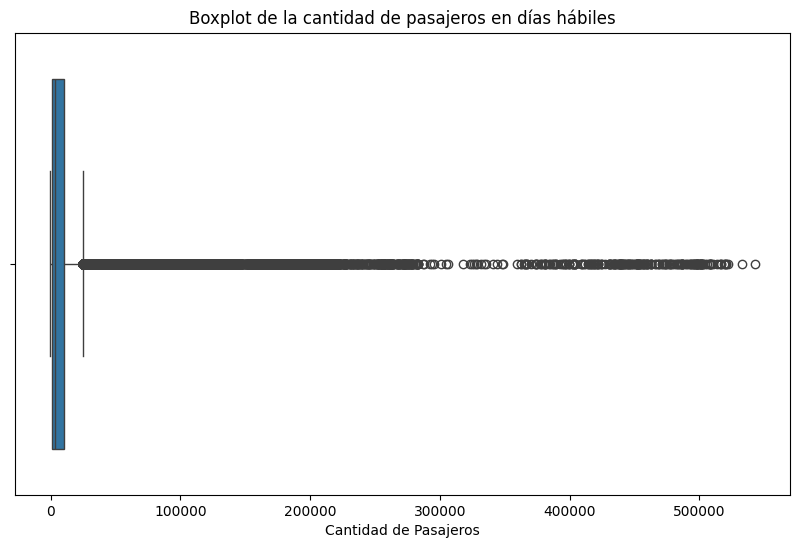

In [39]:

# Visualizar los outliers con un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='CANTIDAD', data=dias_habiles)
plt.title('Boxplot de la cantidad de pasajeros en días hábiles')
plt.xlabel('Cantidad de Pasajeros')
plt.show()

In [40]:
# Investigar las fechas de los outliers
print(outliers[['DIA_TRANSPORTE', 'CANTIDAD', 'FECHA_DIA']])


       DIA_TRANSPORTE  CANTIDAD FECHA_DIA
933        2023-01-02     25053    Monday
940        2023-01-02     45269    Monday
941        2023-01-02     29962    Monday
944        2023-01-02     55611    Monday
946        2023-01-02     30397    Monday
...               ...       ...       ...
469266     2023-12-29     69877    Friday
469678     2023-12-29     31330    Friday
469688     2023-12-29     30175    Friday
469750     2023-12-29    158478    Friday
469755     2023-12-29    170507    Friday

[42761 rows x 3 columns]


In [41]:
# !pip install geopandas matplotlib

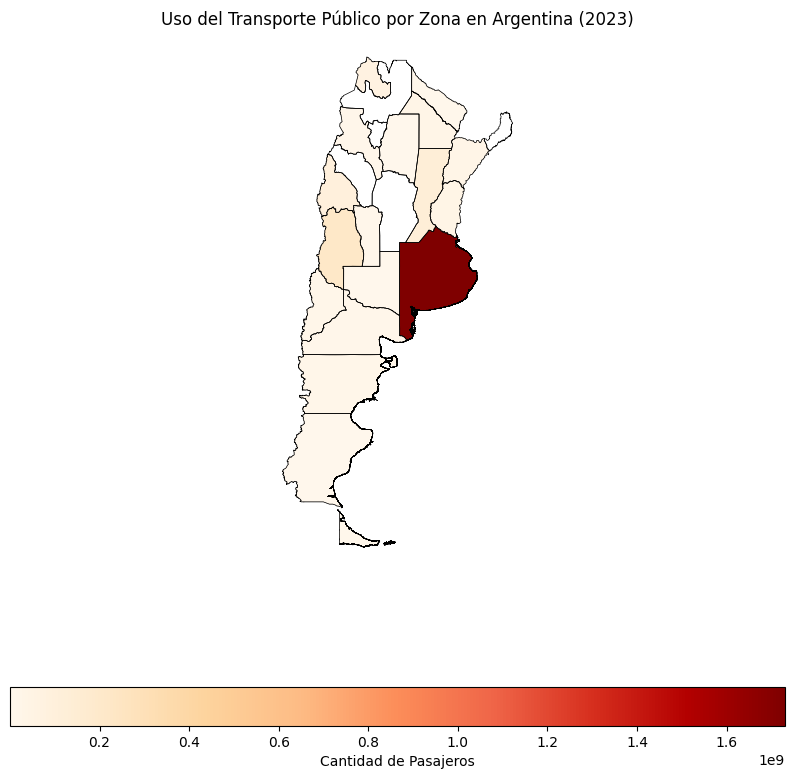

In [97]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Cargar shapefile de Argentina
argentina_shapefile = gpd.read_file('./gadm41_ARG_shp/gadm41_ARG_1.shp')

# Normalizar los nombres de las provincias para asegurar coincidencias
argentina_shapefile['NAME_1'] = argentina_shapefile['NAME_1'].str.upper().str.strip()
df = pd.read_csv('./sube-2023.csv')
df['PROVINCIA'] = df['PROVINCIA'].str.upper().str.strip()

# Agrupar los datos por región/provincia y sumar la cantidad de pasajeros
uso_por_zona = df.groupby('PROVINCIA')['CANTIDAD'].sum().reset_index()

# Unir los datos de uso con el shapefile
argentina_shapefile = argentina_shapefile.merge(uso_por_zona, left_on='NAME_1', right_on='PROVINCIA', how='left')

# Crear el gráfico con bordes más finos para las provincias
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
argentina_shapefile.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')  # Dibujar los bordes de las provincias con un grosor más fino
argentina_shapefile.plot(column='CANTIDAD', ax=ax, legend=True, cmap='OrRd',
                         legend_kwds={'label': "Cantidad de Pasajeros",
                                      'orientation': "horizontal"},
                         edgecolor='black', linewidth=0.1)  # Agregar bordes más finos a las provincias

# Personalizar el gráfico
ax.set_title('Uso del Transporte Público por Zona en Argentina (2023)')
ax.set_axis_off()

# Mostrar el gráfico
plt.show()


Recordemos que la segunda provincia más poblada es Córdoba, pero tienen otro sistema único de boleto electrónico, por eso se aprecia en el mapa el color blanco a pesar de su densa población. Lo corroboramos con la cantidad de transacciones en la provincia de Cordoba:

In [101]:
display(datos[datos['PROVINCIA'] == 'CORDOBA']['CANTIDAD'].nunique())

139

El siguiente box es para conocer la estructura con la que vamos a trabajar para ver el mapa Argentino

In [90]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al archivo .shp
shapefile_path = './gadm41_ARG_shp/gadm41_ARG_2.shp'

# Cargar shapefile de Argentina
argentina_shapefile = gpd.read_file(shapefile_path)

# Verificar las columnas disponibles
print(argentina_shapefile.columns)


Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')


In [106]:
print(argentina_shapefile['NAME_1'].unique())
print(df['PROVINCIA'].unique())

print(len(argentina_shapefile['NAME_1'].unique()))
print(len(df['PROVINCIA'].unique()))


['BUENOS AIRES' 'CATAMARCA' 'CHACO' 'CHUBUT' 'CIUDAD DE BUENOS AIRES'
 'CÓRDOBA' 'CORRIENTES' 'ENTRE RÍOS' 'FORMOSA' 'JUJUY' 'LA PAMPA'
 'LA RIOJA' 'MENDOZA' 'MISIONES' 'NEUQUÉN' 'RÍO NEGRO' 'SALTA' 'SAN JUAN'
 'SAN LUIS' 'SANTA CRUZ' 'SANTA FE' 'SANTIAGO DEL ESTERO'
 'TIERRA DEL FUEGO' 'TUCUMÁN']
['BUENOS AIRES' 'JN' 'CHUBUT' nan 'SANTA FE' 'ENTRE RÍOS' 'LA PAMPA'
 'MENDOZA' 'RÍO NEGRO' 'TIERRA DEL FUEGO' 'CHACO' 'JUJUY' 'NEUQUÉN'
 'FORMOSA' 'CORRIENTES' 'CATAMARCA' 'SAN JUAN' 'SAN LUIS' 'CORDOBA'
 'SANTA CRUZ' 'SANTIAGO DEL ESTERO']
24
21
